### Experimenting with data and Unsupervised Learning

Labels come from 2 different PSG systems: Remlogic and Somnomedics. EMFIT is the piezoelectric mat and Somnofy is the radar. Sleep stage labels are as follows:

0 = Awake \
1 = REM \
2 = Light  \
3 = Deep 


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from loader import *
from helpers import *
import pandas as pd
import numpy as np 

In [50]:
x, y, x_big, y_big = get_nn_patients(raw=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((35, 857, 9), (16, 857, 9), (35, 857), (16, 857))

In [51]:
feature_count = x_train.shape[2]
train_size, test_size = x_train.shape[0] * x_train.shape[1], x_test.shape[0] * x_test.shape[1]
x_tr, x_te, y_tr, y_te = x_train.reshape(train_size, feature_count), x_test.reshape(test_size, feature_count), y_train.ravel(), y_test.ravel()
x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((29995, 9), (13712, 9), (29995,), (13712,))

### Decision Tree with Featured Data

In [76]:
# Selecting the Best important features according to Logistic Regression
# Getting top 2 features shows the best as radar and mat, hence the other features were not used in other methods.
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select=2, step = 1)
rfe_selector.fit(x_tr, y_tr)
print(rfe_selector.get_support())
# top 2: [0,2] = radar sleep stages and emfit sleep stages

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[ True False  True False False False False False False]


In [78]:
# Selecting the Best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select=3, step = 1)
rfe_selector.fit(x_tr, y_tr)
print(rfe_selector.get_support())
# top 5: [0,2,4,5,8]
# top 3: [0,2,5]
x_featured_tr, x_featured_te = x_tr[:,[0,2,5]], x_te[:,[0,2,5]]

/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elifkurtay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

[ True False  True False False  True False False False]


In [79]:
classifier_feature = DecisionTreeClassifier()
classifier_feature.fit(x_featured_tr, y_tr) 
preds = classifier_feature.predict(x_featured_te)

In [80]:
print(classification_report(y_te,preds))
print(balanced_accuracy_score(y_te,preds))
print(accuracy_score(y_te,preds))

              precision    recall  f1-score   support

         0.0       0.67      0.48      0.56      3679
         1.0       0.53      0.65      0.58      1920
         2.0       0.65      0.70      0.67      6382
         3.0       0.55      0.56      0.56      1731

    accuracy                           0.62     13712
   macro avg       0.60      0.60      0.59     13712
weighted avg       0.62      0.62      0.61     13712

0.5986087839709145
0.6169778296382731


### KMeans as a try for Unsupervised Learning

In [81]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(x_tr)

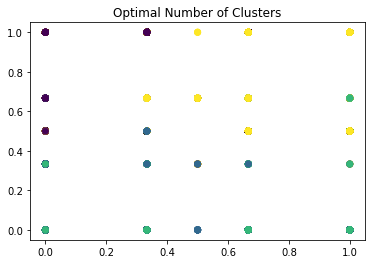

In [82]:
plt.scatter(x_tr[:, 0], x_tr[:, 1], c=y_km)
plt.title("Optimal Number of Clusters")
plt.show()

In [83]:
mapping = {0:1, 1:0, 2:3, 3:2}
preds = [mapping[i] for i in y_km]

In [84]:
print(classification_report(y_tr,preds))
print(balanced_accuracy_score(y_tr,preds))
print(accuracy_score(y_tr,preds))

              precision    recall  f1-score   support

         0.0       0.35      0.27      0.30      6119
         1.0       0.15      0.13      0.14      4891
         2.0       0.52      0.55      0.54     14112
         3.0       0.19      0.23      0.21      4873

    accuracy                           0.37     29995
   macro avg       0.30      0.30      0.30     29995
weighted avg       0.37      0.37      0.37     29995

0.295146380799364
0.37299549924987496
